# 3D UMAP Visualization of Semantic Space

Creates interactive visualizations of semantic space using UMAP dimensionality reduction with the causal metric.

## Approach

1. Sample tokens randomly (to avoid vocabulary ordering bias)
2. Compute pairwise **causal distances** using M
3. Use UMAP with `metric='precomputed'` to find 2D and 3D embeddings
4. Validate structure with Hopkins statistic and community detection
5. Visualize with both static and interactive plots

**Why this is cool:** We get to actually *see* the curved, non-Euclidean geometry of semantic space!

## Configuration

In [15]:
# Path to saved metric tensor
TENSOR_PATH = "../data/vectors/causal_metric_tensor_qwen3_4b.pt"

# Visualization parameters
N_VIZ = 6000  # Sample size for visualization
K_NEIGHBORS = 15  # UMAP parameter: number of neighbors
MIN_DIST = 0.1  # UMAP parameter: minimum distance between points
RANDOM_SEED = 42  # For reproducibility

## Setup

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import community as community_louvain
from collections import Counter
from sklearn.neighbors import NearestNeighbors
from umap import UMAP
from transformers import AutoTokenizer, AutoModelForCausalLM
from pathlib import Path
import pickle

## Load Data

In [17]:
print(f"Loading data from {TENSOR_PATH}...")
data = torch.load(TENSOR_PATH)

M = data['M']
MODEL_NAME = data['metadata']['model']

# Load tokenizer for token string decoding
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Reload model to get gamma
print(f"Loading model {MODEL_NAME} to extract gamma...")
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16,
    device_map=device,
)
model.eval()

gamma = model.lm_head.weight.data.to(dtype=torch.float32, device=device)
vocab_size, hidden_dim = gamma.shape

print(f"\nUnembedding matrix: {gamma.shape}")
print(f"Metric tensor: {M.shape}")
print(f"Device: {device}")

Loading data from ../data/vectors/causal_metric_tensor_qwen3_4b.pt...
Loading model Qwen/Qwen3-4B-Instruct-2507 to extract gamma...


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


Unembedding matrix: torch.Size([151936, 2560])
Metric tensor: torch.Size([2560, 2560])
Device: mps


## Helper Function

In [18]:
def compute_causal_distances(embeddings, M_matrix):
    """Compute pairwise causal distances: d(x,y) = sqrt((x-y)^T M (x-y))"""
    n = embeddings.shape[0]
    distances = torch.zeros(n, n, device=embeddings.device, dtype=embeddings.dtype)
    
    batch_size = 100
    for i in range(0, n, batch_size):
        i_end = min(i + batch_size, n)
        for j in range(0, n, batch_size):
            j_end = min(j + batch_size, n)
            
            diff = embeddings[i:i_end, None, :] - embeddings[None, j:j_end, :]
            temp = torch.einsum('ijk,kl->ijl', diff, M_matrix)
            dist_squared = torch.einsum('ijk,ijk->ij', temp, diff)
            distances[i:i_end, j:j_end] = torch.sqrt(torch.clamp(dist_squared, min=0))
    
    return distances

print("✓ compute_causal_distances defined")

✓ compute_causal_distances defined


## Sample Tokens and Compute Distances

In [19]:
print(f"\nSampling {N_VIZ} random tokens...")
print("(Random sampling avoids vocabulary ordering bias)")

torch.manual_seed(RANDOM_SEED)
viz_token_indices = torch.randperm(vocab_size)[:N_VIZ]
viz_embeddings = gamma[viz_token_indices]

# Decode token strings for hover labels
token_strings = [tokenizer.decode([idx.item()]) for idx in viz_token_indices]

print("\nComputing causal distances...")
viz_distances = compute_causal_distances(viz_embeddings, M)
print(f"Distance matrix shape: {viz_distances.shape}")


Sampling 6000 random tokens...
(Random sampling avoids vocabulary ordering bias)

Computing causal distances...
Distance matrix shape: torch.Size([6000, 6000])


## Run UMAP: 2D Embedding

2D projections are often easier to interpret than 3D — patterns are clearer without rotation.

In [20]:
print("Running UMAP for 2D embedding...")

reducer_2d = UMAP(
    n_components=2,
    metric='precomputed',
    n_neighbors=K_NEIGHBORS,
    min_dist=MIN_DIST,
    random_state=RANDOM_SEED,
    verbose=True
)

embedding_2d = reducer_2d.fit_transform(viz_distances.cpu().numpy())

print(f"\n✓ 2D UMAP embedding complete: {embedding_2d.shape}")

Running UMAP for 2D embedding...


/Users/jefferyharrell/Projects/Azimuth/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning:

using precomputed metric; inverse_transform will be unavailable

/Users/jefferyharrell/Projects/Azimuth/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



UMAP(metric='precomputed', n_jobs=1, random_state=42, verbose=True)
Sun Oct 26 14:22:20 2025 Construct fuzzy simplicial set
Sun Oct 26 14:22:20 2025 Finding Nearest Neighbors
Sun Oct 26 14:22:22 2025 Finished Nearest Neighbor Search
Sun Oct 26 14:22:22 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Oct 26 14:22:32 2025 Finished embedding

✓ 2D UMAP embedding complete: (6000, 2)


## Visualize: 2D (Token ID Colors)

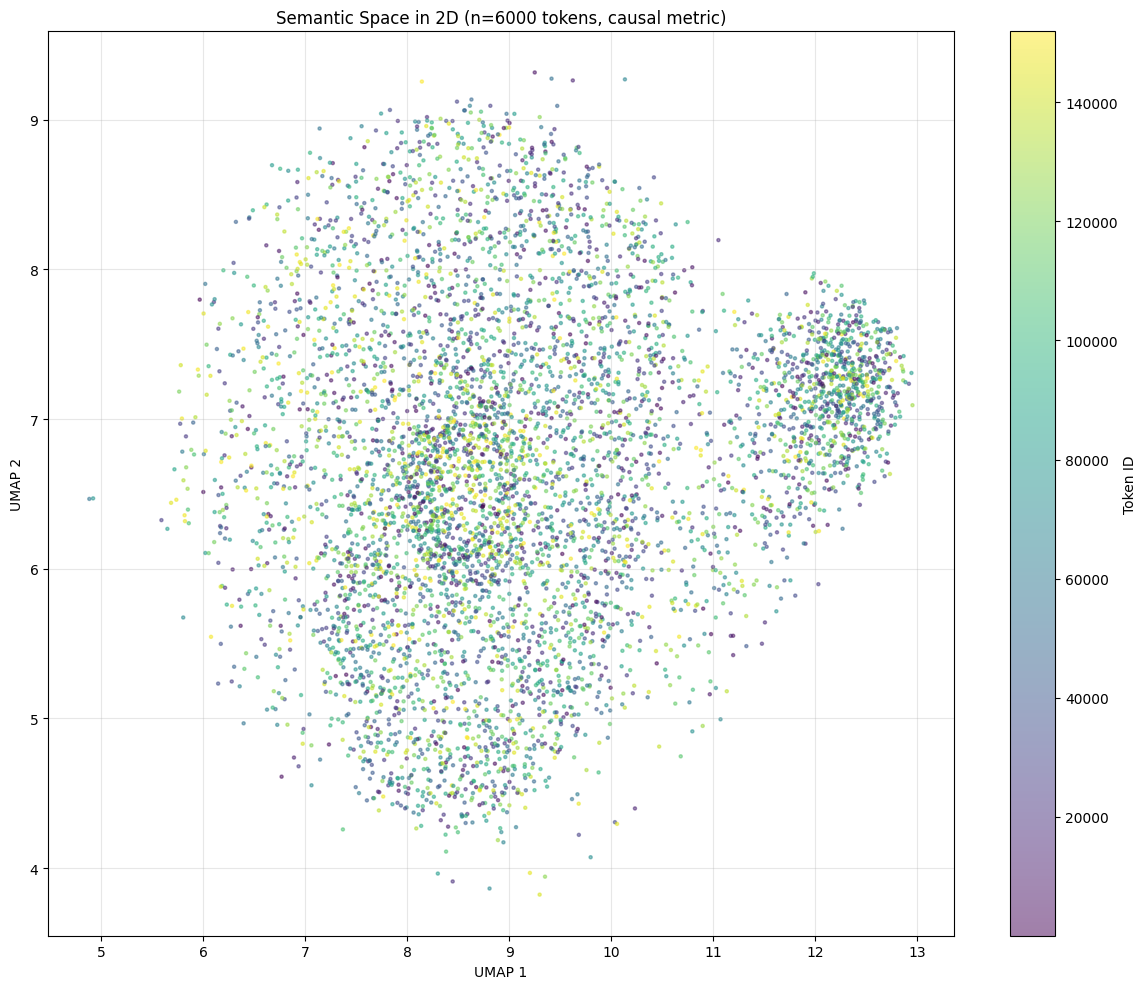

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=viz_token_indices.cpu().numpy(),
    cmap='viridis',
    s=5,
    alpha=0.5
)

plt.colorbar(scatter, label='Token ID')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title(f'Semantic Space in 2D (n={N_VIZ} tokens, causal metric)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Validate: Is This Structure Real?

Let's test whether the visible structure is genuine semantic organization or just noise/artifacts.

We'll:
1. Compute **Hopkins statistic** (clustering tendency: 0.5=random, 1.0=highly clustered)
2. Run **community detection** on original causal distances
3. Color by **community assignments** to see if they align with visual clusters

In [22]:
def hopkins_statistic(X, sample_size=500):
    """
    Compute Hopkins statistic for clustering tendency.
    
    Returns value in [0, 1]:
    - ~0.5: uniformly random (no clustering)
    - close to 1: highly clustered
    """
    n, d = X.shape
    m = min(sample_size, n // 10)
    
    # Sample m points from data
    sample_indices = np.random.choice(n, m, replace=False)
    X_sample = X[sample_indices]
    
    # Generate m uniform random points in the data range
    X_min, X_max = X.min(axis=0), X.max(axis=0)
    X_random = np.random.uniform(X_min, X_max, size=(m, d))
    
    # Nearest neighbor distances for real data
    nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    distances_real, _ = nbrs.kneighbors(X_sample)
    u = distances_real[:, 1]  # Distance to nearest neighbor (excluding self)
    
    # Nearest neighbor distances for random points
    distances_random, _ = nbrs.kneighbors(X_random)
    w = distances_random[:, 0]  # Distance to nearest real point
    
    H = w.sum() / (u.sum() + w.sum())
    return H

print("Computing Hopkins statistic...")
hopkins = hopkins_statistic(embedding_2d, sample_size=500)
print(f"\nHopkins statistic: {hopkins:.4f}")
print(f"  0.5 = uniformly random (no clustering)")
print(f"  1.0 = highly clustered")

if hopkins > 0.75:
    print("\n✓ STRONG clustering tendency detected - structure is REAL")
elif hopkins > 0.6:
    print("\n⚠️  MODERATE clustering tendency - some structure present")
else:
    print("\n⚠️  WEAK clustering tendency - may be mostly noise")

Computing Hopkins statistic...

Hopkins statistic: 0.8826
  0.5 = uniformly random (no clustering)
  1.0 = highly clustered

✓ STRONG clustering tendency detected - structure is REAL


## Community Detection on Original Distances

Run Louvain on the **original causal distances** (not the 2D embedding) to avoid circularity.

In [23]:
print("Building k-NN graph for community detection...")

k = 20
n = viz_distances.shape[0]

neighbors = {}
for i in range(n):
    dists = viz_distances[i].cpu().numpy()
    dists[i] = np.inf
    knn_indices = np.argpartition(dists, k)[:k]
    neighbors[i] = set(knn_indices.tolist())

edges = []
edge_set = set()
for i in range(n):
    for j in neighbors[i]:
        if (i, j) not in edge_set and (j, i) not in edge_set:
            weight = viz_distances[i, j].item()
            edges.append((i, j, weight))
            edge_set.add((i, j))

G = nx.Graph()
G.add_nodes_from(range(n))
for i, j, w in edges:
    G.add_edge(i, j, weight=w)

print("Running Louvain community detection...")
partition = community_louvain.best_partition(G, random_state=RANDOM_SEED)

community_ids = np.array([partition[i] for i in range(n)])
n_communities = len(set(community_ids))
modularity = community_louvain.modularity(partition, G)

print(f"\nFound {n_communities} communities")
print(f"Modularity: {modularity:.4f}")

sizes = sorted(Counter(community_ids).values(), reverse=True)
print(f"Community sizes: {sizes[:5]}..." if len(sizes) > 5 else f"Community sizes: {sizes}")

Building k-NN graph for community detection...
Running Louvain community detection...

Found 4 communities
Modularity: 0.4904
Community sizes: [1664, 1653, 1477, 1206]


## Visualize: 2D (Community Colors)

If communities align with visual clusters, the structure is semantically meaningful!

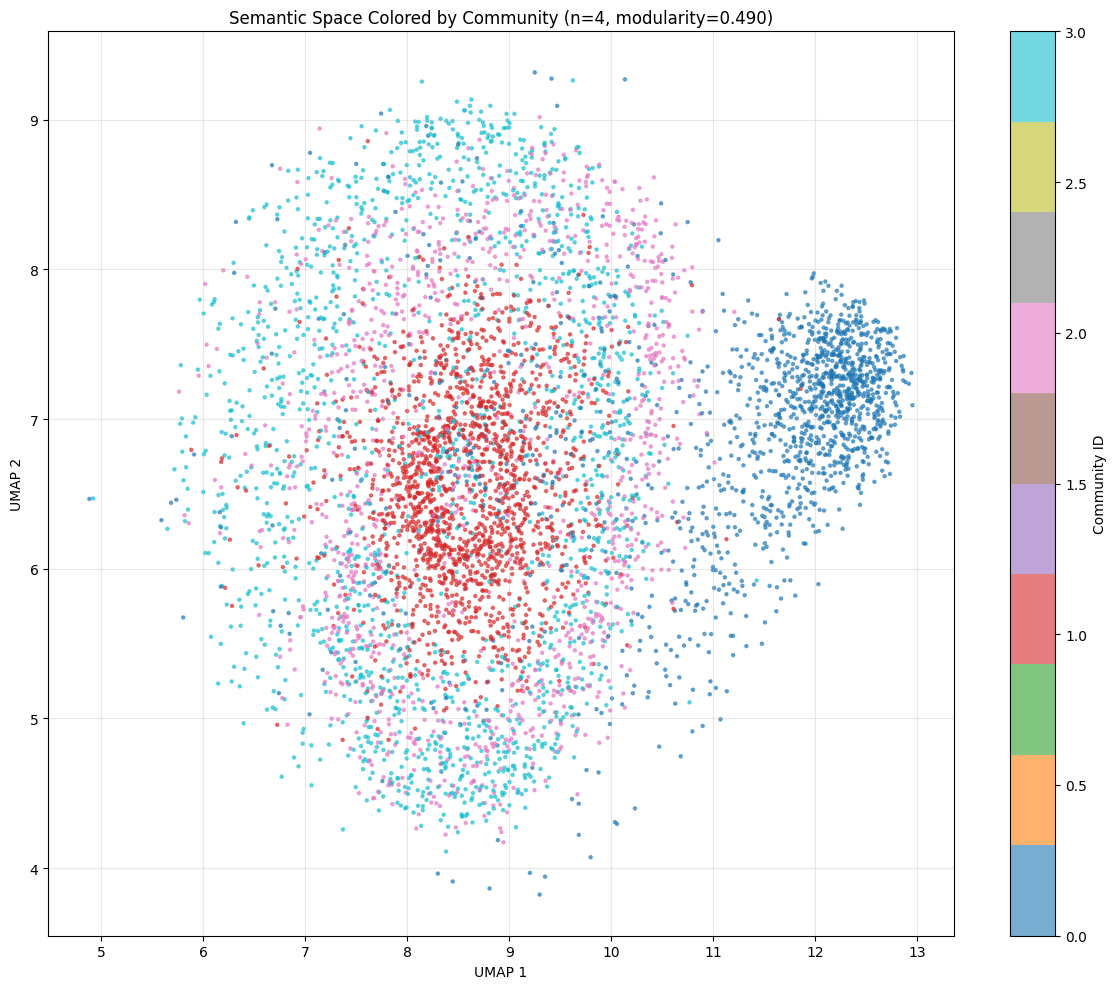


💡 Do the community colors align with the visual clusters you saw?
💡 If yes, the structure is semantically meaningful!


In [24]:
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(
    embedding_2d[:, 0],
    embedding_2d[:, 1],
    c=community_ids,
    cmap='tab10' if n_communities <= 10 else 'viridis',
    s=5,
    alpha=0.6
)

plt.colorbar(scatter, label='Community ID')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_title(f'Semantic Space Colored by Community (n={n_communities}, modularity={modularity:.3f})')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Do the community colors align with the visual clusters you saw?")
print("💡 If yes, the structure is semantically meaningful!")

## Run UMAP: 3D Embedding

3D provides more information but can be harder to interpret without rotation.

In [25]:
print("Running UMAP for 3D embedding...")

reducer_3d = UMAP(
    n_components=3,
    metric='precomputed',
    n_neighbors=K_NEIGHBORS,
    min_dist=MIN_DIST,
    random_state=RANDOM_SEED,
    verbose=True
)

embedding_3d = reducer_3d.fit_transform(viz_distances.cpu().numpy())

print(f"\n✓ 3D UMAP embedding complete: {embedding_3d.shape}")

Running UMAP for 3D embedding...
UMAP(metric='precomputed', n_components=3, n_jobs=1, random_state=42, verbose=True)
Sun Oct 26 14:22:48 2025 Construct fuzzy simplicial set
Sun Oct 26 14:22:48 2025 Finding Nearest Neighbors


/Users/jefferyharrell/Projects/Azimuth/.venv/lib/python3.12/site-packages/umap/umap_.py:1865: UserWarning:

using precomputed metric; inverse_transform will be unavailable

/Users/jefferyharrell/Projects/Azimuth/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Sun Oct 26 14:22:50 2025 Finished Nearest Neighbor Search
Sun Oct 26 14:22:50 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Oct 26 14:23:00 2025 Finished embedding

✓ 3D UMAP embedding complete: (6000, 3)


## Visualize: 3D Interactive (Token ID Colors)

In [26]:
fig = go.Figure(data=[go.Scatter3d(
    x=embedding_3d[:, 0],
    y=embedding_3d[:, 1],
    z=embedding_3d[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=viz_token_indices.cpu().numpy(),
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Token ID"),
        opacity=0.3,
    ),
    text=token_strings,
    hovertemplate='<b>%{text}</b><br>ID: %{marker.color}<br>x: %{x:.2f}<br>y: %{y:.2f}<br>z: %{z:.2f}<extra></extra>',
)])

fig.update_layout(
    title=f'Semantic Space in 3D (n={N_VIZ} tokens, causal metric)',
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    width=900,
    height=700,
)

fig.show()

print("\n💡 Tip: Use mouse to rotate, scroll to zoom, double-click to reset view")
print("💡 Hover over points to see token strings")


💡 Tip: Use mouse to rotate, scroll to zoom, double-click to reset view
💡 Hover over points to see token strings


## Visualize: 3D Interactive (Community Colors)

In [27]:
fig_communities = go.Figure(data=[go.Scatter3d(
    x=embedding_3d[:, 0],
    y=embedding_3d[:, 1],
    z=embedding_3d[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=community_ids,
        colorscale='Plotly3',
        showscale=True,
        colorbar=dict(title="Community"),
        opacity=0.6,
    ),
    text=[f"{s} (C{c})" for s, c in zip(token_strings, community_ids)],
    hovertemplate='<b>%{text}</b><br>x: %{x:.2f}<br>y: %{y:.2f}<br>z: %{z:.2f}<extra></extra>',
)])

fig_communities.update_layout(
    title=f'Semantic Space Colored by Community (n={n_communities} communities)',
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=1.5)
        )
    ),
    width=900,
    height=700,
)

fig_communities.show()

print("\n💡 Now you can see WHERE the semantic communities live in 3D space!")


💡 Now you can see WHERE the semantic communities live in 3D space!


## Optional: Save Embeddings

In [28]:
# Uncomment to save
# output_data = {
#     'embedding_2d': embedding_2d,
#     'embedding_3d': embedding_3d,
#     'token_indices': viz_token_indices.cpu().numpy(),
#     'token_strings': token_strings,
#     'community_ids': community_ids,
#     'parameters': {
#         'n_samples': N_VIZ,
#         'k_neighbors': K_NEIGHBORS,
#         'min_dist': MIN_DIST,
#         'random_seed': RANDOM_SEED,
#     }
# }
# 
# with open('../data/vectors/umap_embeddings.pkl', 'wb') as f:
#     pickle.dump(output_data, f)
# 
# print("✓ Embeddings saved")

## Summary

This notebook visualizes semantic space under the causal metric in both 2D and 3D.

**Key findings:**
- **Hopkins statistic** quantifies clustering tendency
- **Community detection** reveals semantic structure
- **2D plots** make patterns easy to see
- **3D plots** preserve more information but require rotation

**Interpretation:** The visualizations reveal how the causal metric organizes tokens into semantic regions. Positive curvature manifests as dense clustering, and community detection identifies the major semantic categories.

**Next:** Notebook 05 compares L2 vs causal norms for layer selection in steering vector extraction.